In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [25]:
#data_00="/home/mustapha/Downloads/Predictive-Modeling-of-Ionic-Conductivity-in-Garnet-Type-Solid-Electrolytes-main/Data/data_65.csv"
file_path = "/home/mustapha/Downloads/data_augmented.xlsx"
file_path1 = "/home/mustapha/Downloads/Predictive-Modeling-of-Ionic-Conductivity-in-Garnet-Type-Solid-Electrolytes-main/Data/data_augmented.xlsx"



#df0 = pd.read_excel(file_path1)
df = pd.read_excel(file_path)
df1 = df.iloc[:176]
df2 = df.iloc[176:]

In [3]:
def transform_to_material_formula(row):
    # Extract the values from each column
    a = row['Li stoichiometry']
    b = row['La stoichiometry']
    c = row['Zr stoichiometry']
    x = row['Li site dopant stoichiometry']
    y = row['La site dopant stoichiometry']
    z = row['Zr site dopant stoichiometry']
    M = row['li_dopant']
    N = row['la_dopant']
    K = row['zr_dopant']



    formula = ''


    if a > 0:
        formula += f'Li{a:.2f}'

    # Add M if x > 0
    if x > 0:
        formula += f'{M}{x:.2f}'

    # Add La with its stoichiometry
    if b > 0:
        formula += f'La{b:.2f}'

    # Add N if y > 0
    if y > 0:
        formula += f'{N}{y:.2f}'

    # Add Zr with its stoichiometry
    if c > 0:
        formula += f'Zr{c:.2f}'

    # Add K if z > 0
    if z > 0:
        formula += f'{K}{z:.2f}'
        
    formula += f'O12'
   
    return formula



# Assuming you have a DataFrame named 'df' and want to create a new column 'MaterialFormula'
df['MaterialFormula'] = df.apply(transform_to_material_formula, axis=1)


In [4]:
def calculate_average_ionic_radius(row):
    ionic_radii = {
        'Li': row['Li site dopant ionic radius'],
        'La': row['La site dopant ionic radius'],
        'Zr': row['Zr site dopant ionic radius']
    }
   
    stoichiometries = {
        'Li': row['Li stoichiometry'],
        'La': row['La stoichiometry'],
        'Zr': row['Zr stoichiometry']
    }
   
    total_radius = 0
    total_atoms = 0
   
    for element in ionic_radii:
        radius = ionic_radii[element]
        stoichiometry = stoichiometries[element]
       
        total_radius += radius * stoichiometry
        total_atoms += stoichiometry
   
    return total_radius / total_atoms

# Apply the function to each row in the DataFrame
df['average_ionic_radius'] = df.apply(calculate_average_ionic_radius, axis=1)

In [5]:
def interpolate_relative_density(df):
    # Sort by 'MaterialFormula' and 'log_cond' to ensure correct interpolation
    df = df.sort_values(by=['MaterialFormula', 'log_cond']).reset_index(drop=True)

    # Interpolate 'Relative density' within each 'MaterialFormula' group
    interpolated = df.groupby('MaterialFormula')['Relative density'].apply(lambda group: group.interpolate(method='linear'))

    # Ensure the index matches the original DataFrame's index
    df['Relative density'] = interpolated.reset_index(level=0, drop=True)

    # Fill remaining missing values with forward fill and backward fill
    df['Relative density'] = df['Relative density'].ffill().bfill()

    return df



#df = interpolate_relative_density(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            361 non-null    object 
 1   Publication year                  359 non-null    float64
 2   T of the conductivity C           349 non-null    float64
 3   Li stoichiometry                  362 non-null    float64
 4   La stoichiometry                  362 non-null    float64
 5   Zr stoichiometry                  362 non-null    float64
 6   Li site dopant stoichiometry      362 non-null    float64
 7   La site dopant stoichiometry      362 non-null    float64
 8   Zr site dopant stoichiometry      362 non-null    float64
 9   Relative density                  280 non-null    float64
 10  Ionic conductivity                359 non-null    float64
 11  log_cond                          359 non-null    float64
 12  Quality 

In [6]:
import pandas as pd
from sklearn.impute import KNNImputer

def knn_impute_relative_density(df, n_neighbors=5):
    # Check if 'log_cond' has any missing values
    if df['log_cond'].isna().all():
        # If 'log_cond' is entirely NaN, skip KNN and just ffill/bfill
        df['Relative density'] = df['Relative density'].ffill().bfill()
    else:
        # Select only the relevant columns for KNN imputation
        impute_df = df[['log_cond', 'Relative density']]

        # Initialize the KNNImputer
        imputer = KNNImputer(n_neighbors=n_neighbors)

        # Apply KNN Imputer
        imputed_values = imputer.fit_transform(impute_df)

        # Replace 'Relative density' column with imputed values
        df['Relative density'] = imputed_values[:, -1]  # Use the last column, which is 'Relative density'

        # Fill remaining missing values with forward fill and backward fill
        df['Relative density'] = df['Relative density'].ffill().bfill()

    return df

# Example usage
df = knn_impute_relative_density(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            361 non-null    object 
 1   Publication year                  359 non-null    float64
 2   T of the conductivity C           349 non-null    float64
 3   Li stoichiometry                  362 non-null    float64
 4   La stoichiometry                  362 non-null    float64
 5   Zr stoichiometry                  362 non-null    float64
 6   Li site dopant stoichiometry      362 non-null    float64
 7   La site dopant stoichiometry      362 non-null    float64
 8   Zr site dopant stoichiometry      362 non-null    float64
 9   Relative density                  362 non-null    float64
 10  Ionic conductivity                359 non-null    float64
 11  log_cond                          359 non-null    float64
 12  Quality 

In [7]:
materials_to_remove = ['Li6.40Al0.20La3.00Zr2.00O12', 'Li6.25Al0.25La3.00Zr2.00O12']
#df = df[~df['MaterialFormula'].isin(materials_to_remove)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            361 non-null    object 
 1   Publication year                  359 non-null    float64
 2   T of the conductivity C           349 non-null    float64
 3   Li stoichiometry                  362 non-null    float64
 4   La stoichiometry                  362 non-null    float64
 5   Zr stoichiometry                  362 non-null    float64
 6   Li site dopant stoichiometry      362 non-null    float64
 7   La site dopant stoichiometry      362 non-null    float64
 8   Zr site dopant stoichiometry      362 non-null    float64
 9   Relative density                  362 non-null    float64
 10  Ionic conductivity                359 non-null    float64
 11  log_cond                          359 non-null    float64
 12  Quality 

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns

def check_monotonicity_with_deviation_removal(df, max_allowed_deviations, deviation_threshold):
    filtered_data = []
    non_increasing_materials = []

    grouped = df.groupby('MaterialFormula')

    for material, group in grouped:
        group_sorted = group.sort_values('Relative density')
        densities = group_sorted['Relative density'].values
        conductivities = group_sorted['log_cond'].values

        # Check for NaN or infinite values and remove them
        if np.any(np.isnan(conductivities)):
            print(f"Skipping material {material} due to NaN values.")
            continue

        if np.any(np.isinf(densities)) or np.any(np.isinf(conductivities)):
            print(f"Skipping material {material} due to infinite values.")
            continue

        # Handle materials with only one unique density value
        if len(np.unique(densities)) < 2:
            print(f"Including material {material} with a single unique 'Relative density' value.")
            filtered_data.append(group_sorted)
            continue

        # Fit a linear model to capture the average increasing trend
        slope, intercept, _, _, _ = linregress(densities, conductivities)

        # Check if the slope is positive
        if slope <= 0:
            non_increasing_materials.append(material)
            continue

        expected_trend = intercept + slope * densities
        deviations = conductivities - expected_trend
        significant_deviations = np.abs(deviations) > deviation_threshold

        # If the number of significant deviations is within the allowed limit, filter them out
        if significant_deviations.sum() <= max_allowed_deviations:
            group_filtered = group_sorted[~significant_deviations]
        else:
            # Otherwise, skip the entire material
            continue

        filtered_data.append(group_filtered)

    # Combine filtered data into a single DataFrame
    filtered_df = pd.concat(filtered_data)

    # Plot non-increasing materials
    sns.set(style="whitegrid")
    for material in non_increasing_materials:
        group = df[df['MaterialFormula'] == material]
        plt.figure(figsize=(6, 4))
        sns.lineplot(
            x='Relative density',
            y='log_cond',
            data=group,
            marker='o',
            label=material,
        )
        plt.title(f'Non-Increasing Trend for {material}')
        plt.xlabel('Relative density')
        plt.ylabel('log_cond')
        plt.legend()
        plt.show()

    # Remove non-increasing materials from the dataset
    filtered_df = filtered_df[~filtered_df['MaterialFormula'].isin(non_increasing_materials)]

    return filtered_df




Including material Li5.00La3.00Ta2.00O12 with a single unique 'Relative density' value.
Including material Li5.40La2.80Na0.20Nb2.00O12 with a single unique 'Relative density' value.
Including material Li5.50La3.00Zr0.50Ta1.50O12 with a single unique 'Relative density' value.
Including material Li5.80Ga0.40La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li5.80La2.60Na0.40Nb2.00O12 with a single unique 'Relative density' value.
Including material Li5.90Al0.20La3.00Zr1.75W0.25O12 with a single unique 'Relative density' value.
Including material Li5.90Ga0.30La3.00Zr1.80Nb0.20O12 with a single unique 'Relative density' value.
Including material Li5.90La3.00Zr1.45W0.55O12 with a single unique 'Relative density' value.
Including material Li5.95Al0.35La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li5.95Ga0.35La3.00Zr2.00O12 with a single unique 'Relative density' value.
Including material Li6.00La3.00Zr1.00Bi1.00O12 with a si

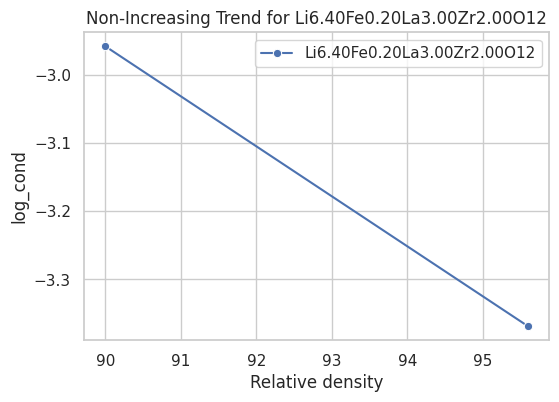

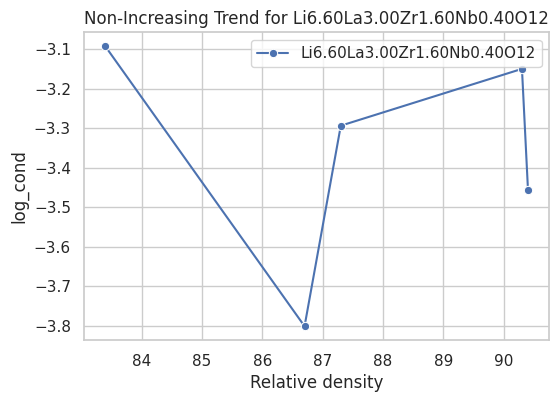

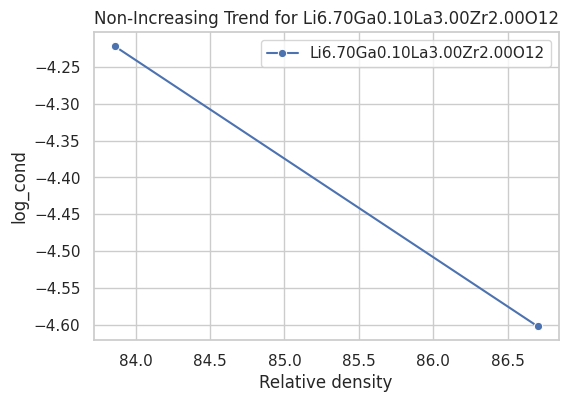

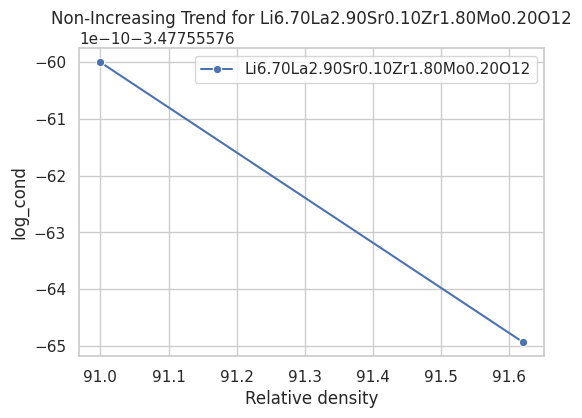

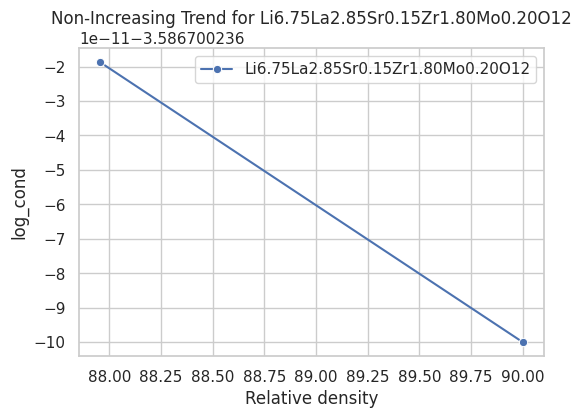

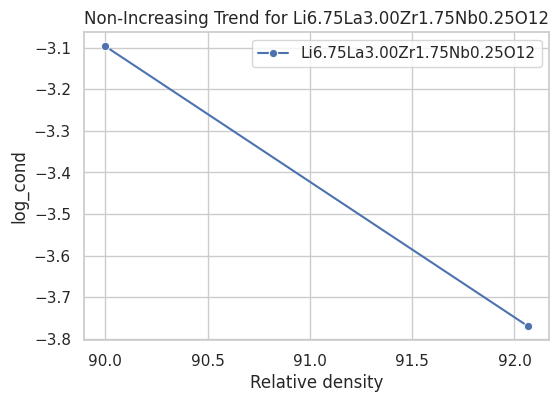

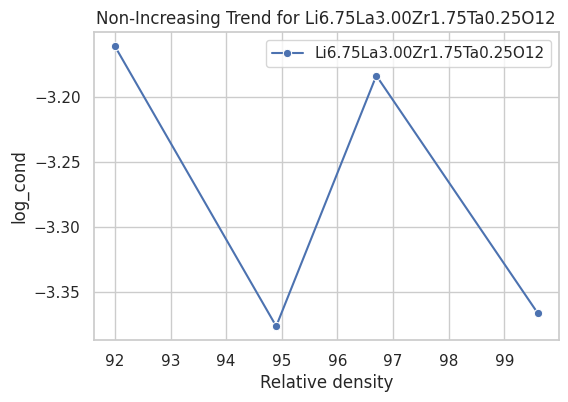

In [9]:

df = check_monotonicity_with_deviation_removal(df, max_allowed_deviations=10, deviation_threshold=.2)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_electric_neutrality(df, tolerance):
    # Ensure DataFrame has necessary columns
    required_columns = [
        'Li stoichiometry', 'La stoichiometry', 'Zr stoichiometry',
        'Li site dopant stoichiometry', 'Li site dopant ion charge',
        'La site dopant stoichiometry', 'La site dopant ion charge',
        'Zr site dopant stoichiometry', 'Zr site dopant ion charge'
    ]
    
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is missing from the DataFrame")

    # Calculate the total charge for each row
    df['Total Charge'] = (
        df['Li stoichiometry'] * 1 +  # Li has a charge of +1
        df['La stoichiometry'] * 3 +  # La has a charge of +3
        df['Zr stoichiometry'] * 4 +  # Zr has a charge of +4
        df['Li site dopant stoichiometry'] * df['Li site dopant ion charge'] +  # Li site dopant charge
        df['La site dopant stoichiometry'] * df['La site dopant ion charge'] +  # La site dopant charge
        df['Zr site dopant stoichiometry'] * df['Zr site dopant ion charge']  # Zr site dopant charge
    )
    
    # Subtract 24 from the total charge to check neutrality
    df['Charge Difference'] = df['Total Charge'] - 24

    # Identify rows that do not satisfy neutrality within the specified tolerance
    non_neutrality_indexes = df[df['Charge Difference'].abs() > tolerance].index

    df_filtered = df.drop(non_neutrality_indexes)

    # Plotting the charge difference
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['Charge Difference'], alpha=0.7, edgecolors='w', s=100)
    plt.axhline(y=0, color='r', linestyle='--', label='Neutrality Line (Charge = 24)')
    plt.axhline(y=tolerance, color='g', linestyle='--', label=f'Neutrality Tolerance ±{tolerance}')
    plt.axhline(y=-tolerance, color='g', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Charge Difference (Total Charge - 24)')
    plt.title('Electric Neutrality of the Material')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_filtered, non_neutrality_indexes

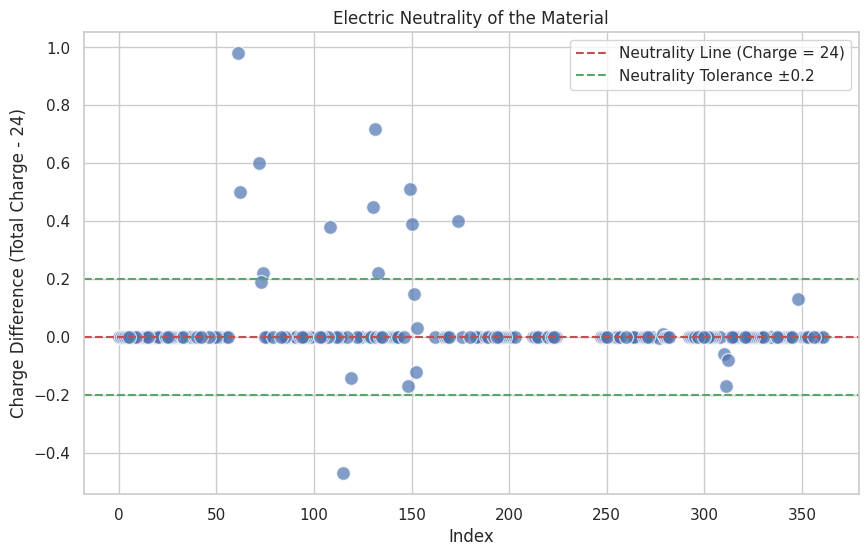

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 51 to 5
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   source                            224 non-null    object 
 1   Publication year                  222 non-null    float64
 2   T of the conductivity C           214 non-null    float64
 3   Li stoichiometry                  224 non-null    float64
 4   La stoichiometry                  224 non-null    float64
 5   Zr stoichiometry                  224 non-null    float64
 6   Li site dopant stoichiometry      224 non-null    float64
 7   La site dopant stoichiometry      224 non-null    float64
 8   Zr site dopant stoichiometry      224 non-null    float64
 9   Relative density                  224 non-null    float64
 10  Ionic conductivity                224 non-null    float64
 11  log_cond                          224 non-null    float64
 12  Quality of ion

In [11]:
df, non_neutrality_indexes = plot_electric_neutrality(df, 0.2)

# Inspect the filtered DataFrame and the indices of non-neutral rows
df.info()

In [12]:
X=df
X = X.drop(['Ionic conductivity'],axis=1)
X = X.drop(['Publication year','Quality of ionic conductivity','source','Doping strategy'], axis=1)
X = X.drop(['MaterialFormula'],axis=1)

# X = X.drop(['Li site dopant ionic radius','La site dopant ionic radius','Zr site dopant ionic radius'], axis=1)
# X = X.drop(['Li site dopant ion charge','La site dopant ion charge','Zr site dopant ion charge'], axis=1)
# X = X.drop(['Li site dopant ionic rad.','La site dopant ionic rad.','Zr site dopant ionic rad.'], axis=1)
X = X.drop(['Li stoichiometry','La stoichiometry', 'Zr stoichiometry'], axis=1)
#X = X.drop(['Li site dopant stoichiometry','La site dopant stoichiometry','Zr site dopant stoichiometry'], axis=1)
# X = X.drop(['Li site dopant electroneg.','La site dopant electroneg.','Zr site dopant electroneg.'], axis=1)
# X = X.drop(['Li site dopant ion charge','La site dopant ion charge','Zr site dopant ion charge'], axis=1)
# X = X.drop(['Li site dopant crystal rad.','La site dopant crystal rad.','Zr site dopant crystal rad.'], axis=1)
# # X = X.drop(['Li site dopant electroneg.','La site dopant electroneg.','Zr site dopant electroneg.'], axis=1)
# X = X.drop(['Li site dopant molar mass','La site dopant molar mass','Zr site dopant molar mass'], axis=1)
X = X.drop(['Li site dopant atomic number','La site dopant atomic number','Zr site dopant atomic number'], axis=1)
# X = X.drop(['Li site dopant e_ionisation','La site dopant e_ionisation','Zr site dopant e_ionisation'], axis=1)
X = X.drop(['Li site dopant electron affinity','La site dopant electron affinity','Zr site dopant electron affinity'], axis=1)
#X = X.drop(['Li site dopant atomic radius','La site dopant atomic radius','Zr site dopant atomic radius'], axis=1)

X = X.drop(['li_dopant','la_dopant','zr_dopant'], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 51 to 5
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   T of the conductivity C          214 non-null    float64
 1   Li stoichiometry                 224 non-null    float64
 2   La stoichiometry                 224 non-null    float64
 3   Zr stoichiometry                 224 non-null    float64
 4   Relative density                 224 non-null    float64
 5   log_cond                         224 non-null    float64
 6   Li site dopant crystal rad.      224 non-null    int64  
 7   Li site dopant ion charge        224 non-null    int64  
 8   Li site dopant electroneg.       224 non-null    float64
 9   Li site dopant molar mass        224 non-null    float64
 10  Li site dopant e_ionisation      224 non-null    float64
 11  Li site dopant atomic radius     224 non-null    int64  
 12  Li site dopant ionic radius 

In [13]:
# Missing values

##########################
# # Sort the DataFrame by the "c" column
# X_sorted = X.sort_values(by='log_cond')

# # # Perform linear interpolation on the "rd" column
# X_filled = X_sorted.interpolate(method='linear', limit_direction='both', inplace=False)
# c=X_filled['log_cond']

# X_filled=X_filled.drop('log_cond', axis=1)

# Y = c
# X_filled.info()


#########################

# X= X[X['Relative density'] >= 80]
# X= X[X['Ionic conductivity'] <= 1.2e-03]
    
# rd_mean = X['Relative density'].mean()
# X = X.fillna({'Relative density': rd_mean})
# Y = X['log_cond']
# X = X.drop(['log_cond'],axis=1)

# X = X.dropna()
# c = X['log_cond']
# X = X.drop(['log_cond'],axis=1)
# Y = c

#########################

from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=3)
# Fit and transform the data to impute the missing values
X_knn = knn_imputer.fit_transform(X)

# Convert the imputed NumPy array back to a DataFrame and specify column names
X_knn = pd.DataFrame(data=X_knn, columns=X.columns)

# Assuming you already have 'Ionic conductivity' in the DataFrame
Y = X_knn['log_cond']

# Drop the 'Ionic conductivity' column from X
X_knn = X_knn.drop('log_cond', axis=1)

In [14]:
X_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   T of the conductivity C          224 non-null    float64
 1   Li stoichiometry                 224 non-null    float64
 2   La stoichiometry                 224 non-null    float64
 3   Zr stoichiometry                 224 non-null    float64
 4   Relative density                 224 non-null    float64
 5   Li site dopant crystal rad.      224 non-null    float64
 6   Li site dopant ion charge        224 non-null    float64
 7   Li site dopant electroneg.       224 non-null    float64
 8   Li site dopant molar mass        224 non-null    float64
 9   Li site dopant e_ionisation      224 non-null    float64
 10  Li site dopant atomic radius     224 non-null    float64
 11  Li site dopant ionic radius      224 non-null    float64
 12  La site dopant crystal

In [15]:
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Define a list of regression models to test
models = [
    HistGradientBoostingRegressor(),
    LinearRegression(),
    Ridge(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor()
]

# Define a list of test split sizes
test_splits = [0.20, 0.25, 0.30]

# Initialize an empty list to store the results
results = []

# Number of iterations
num_iterations = 1

# Iterate over each model
for model in models:
    model_name = type(model).__name__
    
    # Iterate over each test split size
    for test_size in test_splits:
        avg_mse = 0
        avg_r2 = 0
        
        # Run the model multiple times for each test split size
        for _ in range(num_iterations):
            # Split the data into training and testing sets
            X_train, X_test, Y_train, Y_test = train_test_split(X_knn, Y, test_size=test_size, random_state=42, shuffle=True)
            
            # Fit the model and make predictions
            model.fit(X_train, Y_train)
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_test)
            
            # Calculate metrics for this iteration
            mse = mean_squared_error(Y_test, Y_test_pred)
            r2 = r2_score(Y_test, Y_test_pred)
            
            # Update the average metrics
            avg_mse += mse
            avg_r2 += r2
        
        # Calculate the average metrics over the iterations
        avg_mse /= num_iterations
        avg_r2 /= num_iterations
        
        # Append the results to the list
        results.append({
            "Model": model_name, 
            "Test Split Size": test_size, 
            "R-squared (R2)": avg_r2, 
            "Mean Squared Error (MSE)": avg_mse
        })

# Convert the results list to a DataFrame
results_df1 = pd.DataFrame(results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 179, number of used features: 28
[LightGBM] [Info] Start training from score -3.663010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [20]:
results_df1.sort_values(by='R-squared (R2)', ascending=False, inplace=True)


# Resetting the indexes to start from 1
results_df1.reset_index(drop=True, inplace=True)
results_df1

,Model,Test Split Size,R-squared (R2),Mean Squared Error (MSE)
0,CatBoostRegressor,0.20,0.743121,0.103790
1,CatBoostRegressor,0.30,0.702322,0.140352
2,GradientBoostingRegressor,0.30,0.671433,0.154916
3,CatBoostRegressor,0.25,0.654563,0.150209
4,RandomForestRegressor,0.30,0.652231,0.163969
5,HistGradientBoostingRegressor,0.20,0.644072,0.143810
6,GradientBoostingRegressor,0.20,0.643710,0.143957
7,GradientBoostingRegressor,0.25,0.604372,0.172034
8,RandomForestRegressor,0.20,0.601417,0.161045
9,LGBMRegressor,0.20,0.596276,0.163122


In [21]:
import optuna
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# Define test splits to iterate over
test_splits = [0.3,0.25,0.2]

# Initialize a dictionary to store results
results = {}

# Loop over each test split
for test_split in test_splits:
    print(f"\nRunning for test split: {int(test_split * 100)}%")
    
    # Split the data for the current test split
    X_train, X_test, Y_train, Y_test = train_test_split(X_knn, Y, test_size=test_split, random_state=42)
    
    def objective(trial):
        # Define the hyperparameters to tune


        params = {
            'iterations': trial.suggest_int('iterations', 700, 1200),
            'depth': trial.suggest_int('depth', 5, 13),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.02),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
            'border_count': trial.suggest_int('border_count', 32, 300)
        }

        # Train the model with the given parameters
        cat_model = CatBoostRegressor(**params, random_state=42, verbose=0)
        cat_model.fit(X_train, Y_train)
        
        # Predict on the validation set
        y_pred = cat_model.predict(X_test)
        
        # Calculate the R2 score
        r2 = r2_score(Y_test, y_pred)
        
        # Since Optuna minimizes the objective, we need to return the negative R2 score
        return -r2

    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    # Store the best parameters and the best R2 score for this split
    best_params = study.best_params
    best_r2 = -study.best_value
    
    # Train the final model with the best parameters
    final_model = CatBoostRegressor(**best_params, random_state=42, verbose=0)
    final_model.fit(X_train, Y_train)

    # Predict and evaluate the final model
    final_pred = final_model.predict(X_test)
    final_mse = mean_squared_error(Y_test, final_pred)
    final_r2 = r2_score(Y_test, final_pred)
    
    # Store results in the dictionary
    results[int(test_split * 100)] = {
        'Best Parameters': best_params,
        'Best R2 Score': best_r2,
        'Final MSE': final_mse,
        'Final R2 Score': final_r2
    }

# Print all results after training on all splits
print("\nAll Results:")
for split, result in results.items():
    print(f"\nTest Split: {split}%")
    print(f"Best Parameters: {result['Best Parameters']}")

    print(f"Final R2 Score: {result['Final R2 Score']}")


/home/mustapha/Downloads/Predictive-Modeling-of-Ionic-Conductivity-in-Garnet-Type-Solid-Electrolytes-main/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-08-24 15:42:29,299] A new study created in memory with name: no-name-767589e2-30cc-42ac-92a4-341625f6fa78
/tmp/ipykernel_574238/1416351890.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.02),
/tmp/ipykernel_574238/1416351890.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(


Running for test split: 30%


[I 2024-08-24 15:42:32,055] Trial 0 finished with value: -0.6553804195607176 and parameters: {'iterations': 872, 'depth': 12, 'learning_rate': 0.019000180378120252, 'l2_leaf_reg': 5.504467599204385e-05, 'bagging_temperature': 0.6377163348875423, 'border_count': 191}. Best is trial 0 with value: -0.6553804195607176.
/tmp/ipykernel_574238/1416351890.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.02),
/tmp/ipykernel_574238/1416351890.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
/tmp/ipykernel_574238/1416351890.py:26: FutureWar


Running for test split: 25%


[I 2024-08-24 15:43:01,726] Trial 0 finished with value: -0.5895815037726542 and parameters: {'iterations': 813, 'depth': 9, 'learning_rate': 0.019367856870366452, 'l2_leaf_reg': 3.751830172429684e-05, 'bagging_temperature': 0.9025362110111472, 'border_count': 187}. Best is trial 0 with value: -0.5895815037726542.
/tmp/ipykernel_574238/1416351890.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.02),
/tmp/ipykernel_574238/1416351890.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
/tmp/ipykernel_574238/1416351890.py:26: FutureWarn


Running for test split: 20%


[I 2024-08-24 15:43:30,124] Trial 0 finished with value: -0.6931010794190643 and parameters: {'iterations': 1064, 'depth': 10, 'learning_rate': 0.014564736186519888, 'l2_leaf_reg': 0.0001252556819248643, 'bagging_temperature': 0.1804134048927276, 'border_count': 72}. Best is trial 0 with value: -0.6931010794190643.
/tmp/ipykernel_574238/1416351890.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.02),
/tmp/ipykernel_574238/1416351890.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e-3),
/tmp/ipykernel_574238/1416351890.py:26: FutureWar


All Results:

Test Split: 30%
Best Parameters: {'iterations': 927, 'depth': 6, 'learning_rate': 0.012833721410385848, 'l2_leaf_reg': 2.5605812740543563e-05, 'bagging_temperature': 0.24136794381588383, 'border_count': 159}
Final R2 Score: 0.709320817678438

Test Split: 25%
Best Parameters: {'iterations': 811, 'depth': 6, 'learning_rate': 0.01552626727982302, 'l2_leaf_reg': 7.113519834812874e-05, 'bagging_temperature': 0.3235284669549238, 'border_count': 186}
Final R2 Score: 0.6370575171576855

Test Split: 20%
Best Parameters: {'iterations': 1024, 'depth': 10, 'learning_rate': 0.015129872811330144, 'l2_leaf_reg': 0.0007156284128229564, 'bagging_temperature': 0.3692417907812613, 'border_count': 263}
Final R2 Score: 0.754341580494697


In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_knn, Y, test_size=0.2, random_state=42, shuffle=True)


# model1=CatBoostRegressor(bagging_temperature = 0.5, depth = 3, iterations = 214, l2_leaf_reg = 7,
#                          learning_rate = 0.3, random_strength = 0.5)
model1 = CatBoostRegressor()
model1.fit(X_train, Y_train)
Y_train_pred = model1.predict(X_train)
Y_test_pred = model1.predict(X_test)

# Calculate metrics for this iteration
mse = mean_squared_error(Y_test, Y_test_pred)
r2_cat = r2_score(Y_test, Y_test_pred)
print('R2 score for the CatBoostRegressor Model is: ', r2_cat)

Learning rate set to 0.031198
0:	learn: 0.6656289	total: 316us	remaining: 317ms
1:	learn: 0.6584719	total: 611us	remaining: 305ms
2:	learn: 0.6513902	total: 842us	remaining: 280ms
3:	learn: 0.6446484	total: 983us	remaining: 245ms
4:	learn: 0.6377741	total: 1.21ms	remaining: 241ms
5:	learn: 0.6313940	total: 1.43ms	remaining: 236ms
6:	learn: 0.6245560	total: 1.66ms	remaining: 235ms
7:	learn: 0.6178466	total: 1.89ms	remaining: 234ms
8:	learn: 0.6127311	total: 2.13ms	remaining: 234ms
9:	learn: 0.6067528	total: 2.25ms	remaining: 222ms
10:	learn: 0.6008008	total: 2.52ms	remaining: 227ms
11:	learn: 0.5955280	total: 2.83ms	remaining: 233ms
12:	learn: 0.5907069	total: 3.06ms	remaining: 232ms
13:	learn: 0.5842256	total: 3.29ms	remaining: 232ms
14:	learn: 0.5787806	total: 4.17ms	remaining: 274ms
15:	learn: 0.5724370	total: 4.4ms	remaining: 271ms
16:	learn: 0.5680190	total: 4.62ms	remaining: 267ms
17:	learn: 0.5627522	total: 4.84ms	remaining: 264ms
18:	learn: 0.5586879	total: 5.04ms	remaining: 260

In [ ]:
# !pip install shap


Learning rate set to 0.031198
0:	learn: 0.6656289	total: 315us	remaining: 315ms
1:	learn: 0.6584719	total: 566us	remaining: 283ms
2:	learn: 0.6513902	total: 783us	remaining: 261ms
3:	learn: 0.6446484	total: 906us	remaining: 226ms
4:	learn: 0.6377741	total: 1.14ms	remaining: 227ms
5:	learn: 0.6313940	total: 1.47ms	remaining: 243ms
6:	learn: 0.6245560	total: 1.71ms	remaining: 242ms
7:	learn: 0.6178466	total: 1.96ms	remaining: 243ms
8:	learn: 0.6127311	total: 2.2ms	remaining: 243ms
9:	learn: 0.6067528	total: 2.34ms	remaining: 232ms
10:	learn: 0.6008008	total: 2.7ms	remaining: 242ms
11:	learn: 0.5955280	total: 2.95ms	remaining: 243ms
12:	learn: 0.5907069	total: 3.2ms	remaining: 243ms
13:	learn: 0.5842256	total: 3.46ms	remaining: 244ms
14:	learn: 0.5787806	total: 3.71ms	remaining: 244ms
15:	learn: 0.5724370	total: 3.93ms	remaining: 242ms
16:	learn: 0.5680190	total: 4.14ms	remaining: 240ms
17:	learn: 0.5627522	total: 4.35ms	remaining: 237ms
18:	learn: 0.5586879	total: 4.56ms	remaining: 236ms

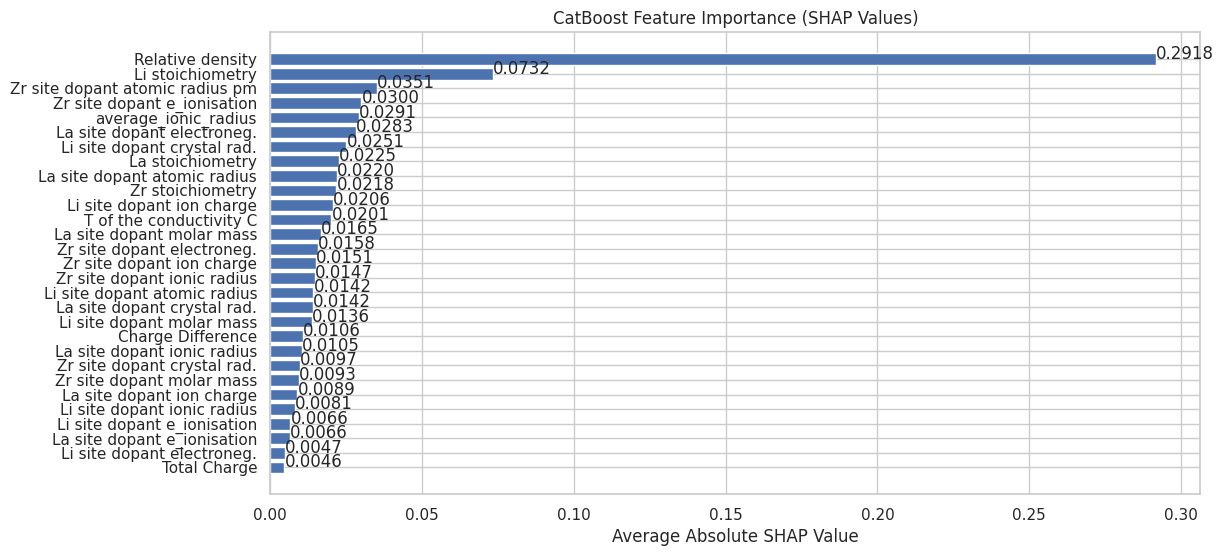

In [23]:
import shap
import matplotlib.pyplot as plt
import numpy as np

catboost_fit = CatBoostRegressor()
catboost_fit.fit(X_train, Y_train)

explainer = shap.Explainer(catboost_fit)
shap_values = explainer.shap_values(X_train)


mean_shap_values = np.abs(shap_values).mean(axis=0)

# Sorting features based on mean SHAP values
sorted_idx = np.argsort(mean_shap_values)

plt.figure(figsize=(12, 6))
plt.barh(np.arange(X_train.shape[1]) + 1, mean_shap_values[sorted_idx], align='center')
plt.yticks(np.arange(X_train.shape[1]) + 1, X_train.columns[sorted_idx])
plt.xlabel('Average Absolute SHAP Value')
plt.title('CatBoost Feature Importance (SHAP Values)')

# Display the values on the plot 
for index, value in enumerate(mean_shap_values[sorted_idx]):
    plt.text(value, index + 1, f'{value:.4f}')

plt.show()


In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(Y_train, Y_train_pred, color='blue', alpha=0.5, label='Train Predictions (CatBoostRegressor)')
# Plot for the test set (blue)
plt.scatter(Y_test, Y_test_pred, color='red', alpha=0.5, label='Test Predictions (CatBoostRegressor)')

plt.plot( [-8,-2.5], [-8,-2.5], 'k--', lw=2)
plt.title('Actual vs. Predicted Values for CatBoostRegressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()



## GradientBoostingRegressor ##

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_knn, Y, test_size=0.25, random_state=42, shuffle=True)

model2 = GradientBoostingRegressor()
model2.fit(X_train, Y_train)
Y_train_pred = model2.predict(X_train)
Y_test_pred = model2.predict(X_test)

# Calculate metrics for this iteration
mse = mean_squared_error(Y_test, Y_test_pred)
r2_g = r2_score(Y_test, Y_test_pred)
print('R2 score for the GradientBoostingRegressor Model is: ', r2_g)

In [ ]:
plt.figure(figsize=(8, 8))


plt.scatter(Y_train, Y_train_pred, color='blue', alpha=0.5, label='Train Predictions (GradientBoostingRegressor)')

# Plot for the test set (blue)
plt.scatter(Y_test, Y_test_pred, color='red', alpha=0.5, label='Test Predictions (GradientBoostingRegressor)')

plt.plot( [-8,-2.5], [-8,-2.5], 'k--', lw=2)
plt.title('Actual vs. Predicted Values for GradientBoostingRegressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()
